In [1]:
import random
import torch
import json
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
import torch_directml
import matplotlib.pyplot as plt

In [51]:
def remove_outliers(price_dict,card_dict, z_thresh=2.0):
    prices = np.array(list(price_dict.values()))
    mean_price = np.mean(prices)
    std_price = np.std(prices)
    z_scores = (prices - mean_price) / std_price
    idx_to_remove = np.where(np.abs(z_scores) > z_thresh)[0]
    print(len(idx_to_remove))
    for idx in idx_to_remove:
        key_to_remove = list(price_dict.keys())[idx]
        if key_to_remove in price_dict:
            del price_dict[key_to_remove]
        if key_to_remove in card_dict:
            del card_dict[key_to_remove]
        
        
def loadPrices(pricePath):
    with open(pricePath, "r") as priceFile:
        uuidToPrice = {}
        prices = json.load(priceFile)
        prices = prices['data']
        nonfoils = set() #Debug Sets
        foils = set()
        nones = set()
        for i in prices:
            if 'paper' in prices[i]:
                for vendor in prices[i]['paper']:
                    priced = False
                    for sellType in ['retail', 'buylist']:
                        if sellType in prices[i]['paper'][vendor]:
                            if 'normal' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['normal'].values())[-1]
                                nonfoils.add(i)
                                priced = True
                                break
                            elif 'foil' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['foil'].values())[-1]
                                foils.add(i)
                                priced = True
                                break
                            else:
                                print(f"No foil or nonfoil {i}")
                    if not priced:
                        nones.add(i)
        print(f"Loaded the Price of {len(uuidToPrice)}/{len(prices)} cards")
        return uuidToPrice
def rarityToNumber(rarity):
    return ["common","uncommon","rare","mythic","special"].index(rarity) + 1
def loadCards(priceDict, cardPath):
    outfile = open("mtgData.csv", "w")
    with open(cardPath, "r") as cardFile:
        uuidToCardData = {}
        data = json.load(cardFile)
        data = data['data']
        priceMisses = set()
        for i in data:
            if data[i]['language'] == 'English' and 'legalities' in data[i] and 'MOM' not in data[i]['printings'] and i in priceDict and len(data[i]['legalities']) != 0:
                uuidToCardData[i] = data[i]
                outfile.write(f"{i},\"{data[i]['name']}\",{rarityToNumber(data[i]['rarity'])},{priceDict[i]}\n")
            if i not in priceDict:
                priceMisses.add(i)
        print(f"Loaded data of {len(uuidToCardData)}/{len(data)} cards")
        return uuidToCardData

mtgCardsPath = "./AllIdentifiers.json"
mtgPricesPath = "./AllPrices.json"
uuidToPrice = loadPrices(mtgPricesPath)
uuidToCard = loadCards(uuidToPrice,mtgCardsPath)
remove_outliers(uuidToPrice,uuidToCard)

Loaded the Price of 70801/79011 cards
Loaded data of 60987/84235 cards


In [3]:
def getOneHot(allClasses, classSubset):
    oneHot = [0] * len(allClasses)
    for c in classSubset:
        try:
            if isinstance(c, str):
                c = c.strip()
            oneHot[allClasses.index(c)] = 1
        except:
            pass
    return oneHot

def prepareData(idToCard):
    # Supertype, subtype, legalities, keywords, artists (left to right 0 indexed)
    classCount = 8
    onehots = [set() for _ in range(classCount)]
    keywords = {}
    for uuid in idToCard:
        entry = idToCard[uuid]
        for t in entry.get('supertypes', []):
            onehots[enum['supertype']].add(t)
        for t in entry.get('subtypes', []):
            onehots[enum['subtype']].add(t)
        for l in entry.get('legalities', []):
            onehots[enum['legalities']].add(l)
        for k in entry.get('keywords', []):
            keywords[k] = keywords.get(k,0)
            keywords[k] += 1
            if keywords[k] > 1:
                onehots[enum['keywords']].add(k)
        if entry.get('artist'):
            onehots[enum['artist']].add(entry['artist'])
        for l in entry.get('printings', []):
            onehots[enum['printings']].add(l)
        rarity = entry.get('rarity', None)
        if rarity is not None:
            onehots[enum['rarity']].add(rarity)
        wordList = entry.get('flavorText',"").replace("\n", "").replace("\"", "").replace("\'", "").replace("-", " ")
        wordList = wordList.split(" ")
        for t in wordList:
            t = t.strip()
            onehots[enum['flavorText']].add(t)

    for s in onehots:
        globalOneHots.append(sorted(list(s)))
    
    globalOneHots.append(sorted(['X','U','B','R','G','W','C','P','S']))
    
                         
        
        
class CustomMTGDataset(Dataset):
    def __init__(self,uuidList, uuidCard, uuidPrice):
        self.uuidList = uuidList
        self.uuidCard = uuidCard
        self.uuidPrice = uuidPrice
        self.ac = 0

    def __len__(self):
        return len(self.uuidList)
    #PROPOSED FEATURE VECTOR V 1
    # CMC (NUMBER)
    # NUMBER OF PIPS (ONE HOT BUT NOT ONE)
    # COLORS (ONE HOT)
    # PRINTINGS (NUMBER)
    # PRINTINGS (ONE HOT)
    # SUBTYPE (ONE HOT)
    # SUPERTYPE (ONE HOT)
    # LEGALITIES (ONE HOT)
    # KEYWORDS (ONE HOT)
    # ARTIST (ONE HOT) ?
    # RARITY (ONE HOT)
    # FLAVOR TEXT (ONE HOT)
    # POWER (NUMBER)
    # TOUGHNESS (NUMBER)
    # LOYALTY (NUMBER)
    # FLAVOR TEXT LENGTH (NUMBER)
    # FLAVOR TEXT (ONE HOT)
    
    def __getitem__(self, idx):
#         self.ac += 1
#         print(self.ac)
        uuid = self.uuidList[idx]
        cardData = self.uuidCard[uuid]
        featureVector = []
        # phrexian = 0
        # # Add 1, so that CMC of 0 is not ignored
        # if 'convertedManaCost' in cardData:
            # featureVector.append(int(cardData['convertedManaCost']) + 1)
        # else:
            # featureVector.append(0)
                         
        # oneHotMana = [0] * len(globalOneHots[enum['pips']])
        # colors = [0] * len(globalOneHots[enum['pips']])   
        # if 'manaCost' in cardData:
            # cost = cardData['manaCost']
            # i = 0
            # while(i < len(cost)):
                # if(cost[i] == '/'):
                    # cost = cost[:i] + "}{" + cost[i+1:]
                # i += 1
            # cost = cost.split("}")
            # for i in range(len(cost)):
                # cost[i] = cost[i].strip("{")
                # if cost[i].isdigit() or cost[i] == '':
                    # continue
                # oneHotMana[globalOneHots[enum['pips']].index(cost[i])] += 1
                # colors[globalOneHots[enum['pips']].index(cost[i])] = 1                     
        # else:
            # for i in cardData['colors']:
                # colors[globalOneHots[enum['pips']].index(i)] = 1
            
        # featureVector.extend(oneHotMana)
        # featureVector.extend(colors)
        
        # featureVector.append(len(cardData.get('printings',[])))
        
        # featureVector.extend(getOneHot(globalOneHots[enum['printings']], cardData.get('printings',[])))
        
        # featureVector.extend(getOneHot(globalOneHots[enum['subtype']], cardData.get('subtype',[])))
                                                      
        # featureVector.extend(getOneHot(globalOneHots[enum['supertype']], cardData.get('supertype',[])))
        
        # featureVector.extend(getOneHot(globalOneHots[enum['legalities']], cardData.get('legalities',[])))
                             
        # featureVector.extend(getOneHot(globalOneHots[enum['keywords']], cardData.get('keywords',[])))
                             
        # featureVector.extend(getOneHot(globalOneHots[enum['artist']], [cardData.get('artist')]))

        featureVector.extend(getOneHot(globalOneHots[enum['rarity']], [cardData.get('rarity')]))
        # featureVector.extend(getOneHot(globalOneHots[enum['flavorText']], cardData.get('flavorText', "").split(" ")))

        # featureVector.append(len(cardData.get("flavorText", "")))

                             
        # cardPower = cardData.get('power', "0")
        # if cardPower.isdigit():
        #     featureVector.append(int(cardPower))
        #     featureVector.append(0)
        # else:
        #     featureVector.append(0)
        #     featureVector.append(1)
        
        
        # cardToughness = cardData.get('toughness', "0")
        # if cardToughness.isdigit():
        #     featureVector.append(int(cardToughness))
        #     featureVector.append(0)
        # else:
        #     featureVector.append(0)
        #     featureVector.append(1)
        
        # cardLoyalty = cardData.get('loyalty', "0")
        # if cardLoyalty.isdigit():
        #     featureVector.append(int(cardLoyalty))
        #     featureVector.append(0)
        # else:
        #     featureVector.append(0)
        #     featureVector.append(1)


        # l = [0] * 5
        # g = ['common', 'uncommon', 'rare', 'mythic', 'special']
        # l[g.index(cardData.get('rarity'))]= 1
        # featureVector.extend(l)
        
        label = torch.tensor(float(self.uuidPrice[uuid]))
        return np.array(featureVector, dtype="float32"), label


In [5]:
def createToyData(uuidToCardMap,uuidToPriceMap, size):
    for i in range(size):
        if i < size/5:
            uuidToPriceMap[i] = 1
            # uuidToPrice[i] = random.randrange(0,1)
            uuidToCardMap[i] = {'rarity' : 'common'}
        elif i < size * 2/5:
            # uuidToPrice[i] = random.randrange(1,10)
            uuidToPriceMap[i] = 10

            uuidToCardMap[i] = {'rarity' : 'uncommon'}
        elif i < size * 3/5:
            uuidToPriceMap[i] = 100
            # uuidToPrice[i] = random.randrange(10,30)
            uuidToCardMap[i] = {'rarity' : 'rare'}
        elif i < size * 4/5:
            uuidToPriceMap[i] = 500
            # uuidToPrice[i] = random.randrange(50,100)

            uuidToCardMap[i] = {'rarity' : 'mythic'}
        else:
            uuidToPriceMap[i] = 1000
            # uuidToPrice[i] = random.randrange(110,150)
            uuidToCardMap[i] = {'rarity' : 'special'}



In [52]:
enum = {'supertype' : 0, 'subtype' : 1, 'legalities' : 2, 'keywords' : 3, 'artist' : 4,'printings' : 5,'rarity' : 6,'flavorText':7,'pips' : 8  }

globalOneHots = []
prepareData(uuidToCard)

# uuidCard = {}
# uuidPrice = {}
# createToyData(uuidCard,uuidPrice,1000)
allCards = list(uuidToCard.keys())
random.shuffle(allCards)
# allCards = list(uuidCard.keys())
print(len(allCards))
trainingDataPercent = 0.8
totalUsage = 0.1
trainingIndex = int(len(allCards)*totalUsage * trainingDataPercent)
print(trainingIndex)

num_epochs = 250         # the number of epochs (each epoch: scanning the entire training set)
batch_size = 500        # how many samples are used in each iteration of SGD/Adam update
learning_rate = 0.0001   # learning rate or step size used in gradient-based optimization algorithm

# train_dataset = CustomMTGDataset(allCards[:trainingIndex],uuidCard,uuidPrice)
train_dataset = CustomMTGDataset(allCards[:trainingIndex],uuidToCard,uuidToPrice)

# test_dataset = CustomMTGDataset(allCards[trainingIndex:],uuidCard,uuidPrice)
test_dataset = CustomMTGDataset(allCards[trainingIndex:],uuidToCard,uuidToPrice)

input_size = len(train_dataset.__getitem__(0)[0])     
# hiddenSizes = [input_size * 2, input_size, input_size//2, input_size//4]  
hiddenSizes = [input_size , input_size, input_size, input_size]  

# hiddenSizes = [input_size*2, input_size*2, input_size, input_size//2]  

print(input_size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

60801
4864
5


In [53]:
class NeuralNet(nn.Module):
    def __init__(self, input_size,h1,h2,h3,h4):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,h4)
        self.fc5 = nn.Linear(h4,1) 
    
        self.r1 = nn.ReLU()
    def forward(self, x):
        out = self.fc1(x)
        out = self.r1(out)
        out = self.fc2(out)
        out = self.r1(out)
        out = self.fc3(out)
        out = self.r1(out)
        out = self.fc4(out)
        out = self.r1(out)
        out = self.fc5(out)
        return out

In [40]:

class HuberLoss(torch.nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        residual = torch.abs(y_pred - y_true)
        condition = (residual < self.delta).float()
        loss = condition * 0.5 * residual ** 2 + (1 - condition) * (self.delta * residual - 0.5 * self.delta ** 2)
        return torch.mean(loss)


Epoch [1/250], Step [10/10], Loss: 32.4933
Epoch [2/250], Step [10/10], Loss: 93.1294
Epoch [3/250], Step [10/10], Loss: 6.4536
Epoch [4/250], Step [10/10], Loss: 10.4254
Epoch [5/250], Step [10/10], Loss: 28.8696
Epoch [6/250], Step [10/10], Loss: 9.6258
Epoch [7/250], Step [10/10], Loss: 11.6123
Epoch [8/250], Step [10/10], Loss: 10.3724
Epoch [9/250], Step [10/10], Loss: 8.9597
Epoch [10/250], Step [10/10], Loss: 39.2311
Epoch [11/250], Step [10/10], Loss: 7.9244
Epoch [12/250], Step [10/10], Loss: 12.0567
Epoch [13/250], Step [10/10], Loss: 14.6240
Epoch [14/250], Step [10/10], Loss: 49.9783
Epoch [15/250], Step [10/10], Loss: 8.3047
Epoch [16/250], Step [10/10], Loss: 17.7209
Epoch [17/250], Step [10/10], Loss: 14.2002
Epoch [18/250], Step [10/10], Loss: 9.6893
Epoch [19/250], Step [10/10], Loss: 12.6972
Epoch [20/250], Step [10/10], Loss: 4.7749
Epoch [21/250], Step [10/10], Loss: 15.6058
Epoch [22/250], Step [10/10], Loss: 5.7796
Epoch [23/250], Step [10/10], Loss: 23.6125
Epoch

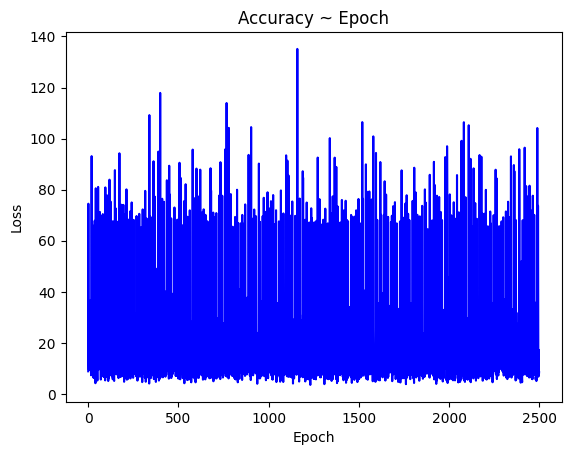

In [54]:
# device = torch_directml.device()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = NeuralNet(input_size,uuidPrice,uuidCard).to(device)
model = NeuralNet(input_size,hiddenSizes[0],hiddenSizes[1],hiddenSizes[2],hiddenSizes[3]).to(device)
# outputs = model(card)
threshold = 0.1
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = HuberLoss(delta=1.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
lossList = []
for epoch in range(num_epochs):
    for i, (cards, labels) in enumerate(train_loader): 
        
        cards = cards.to(device)
        labels = labels.to(device)
        # Backward and optimize
        optimizer.zero_grad() # Zero's out gradients
        outputs = model(cards).squeeze()
        loss = criterion(outputs, labels)
        loss.backward() # Calculates the gradient 
        optimizer.step() # Updates the 
        if i == len(train_loader) - 1:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        lossList.append(loss.item())
plt.plot(lossList, '-b', label='train acc')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Accuracy ~ Epoch')
plt.show()


In [34]:
print(model.fc1.weight)
print(model.fc1.bias)
print(train_dataset[0][1],model(torch.tensor(train_dataset[0][0])))

Parameter containing:
tensor([[-0.3243, -0.4011,  0.2099,  0.2855,  0.3527]], requires_grad=True)
Parameter containing:
tensor([-0.0472], requires_grad=True)
tensor(45.7100) tensor([0.1627], grad_fn=<AddBackward0>)
